**AI Seasonal Pollution Pattern Detector**

Requested city 'Delhi' not found.
Available cities: ['Palkalaiperur']
Proceeding with city 'Palkalaiperur'
Analyzing city: Palkalaiperur
Using date column: date, index column: Index Value
Rows: 175


,date,City,No. Stations,Air Quality,Index Value,Prominent Pollutant
0,2023-03-17,Palkalaiperur,1.0,Satisfactory,52,SO2
1,2023-03-18,Palkalaiperur,1.0,Satisfactory,52,SO2
2,2023-03-19,Palkalaiperur,1.0,Satisfactory,53,SO2


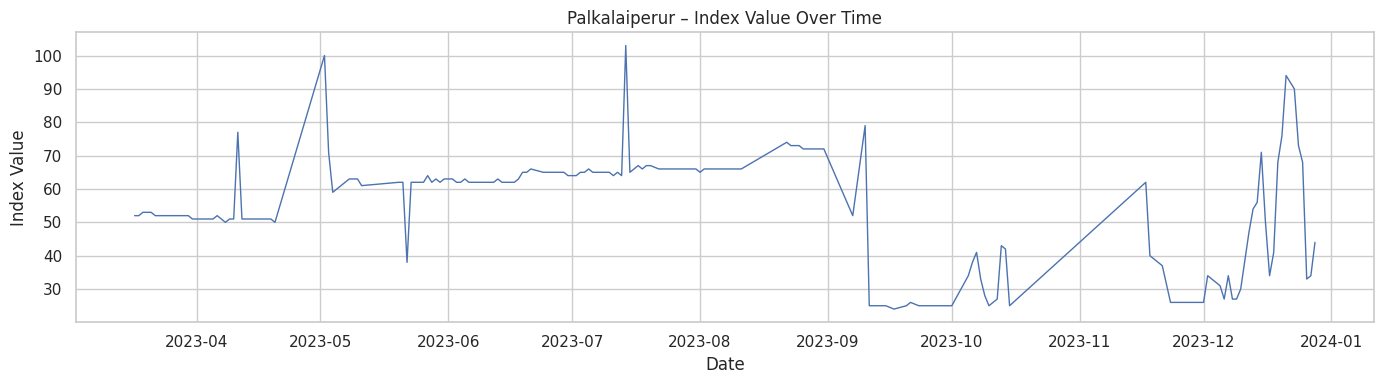


Missing Index Value readings: 0 (0.00%)
Date range: 2023-03-17 00:00:00 → 2023-12-28 00:00:00

Abnormal entries detected: 0
No outliers detected.


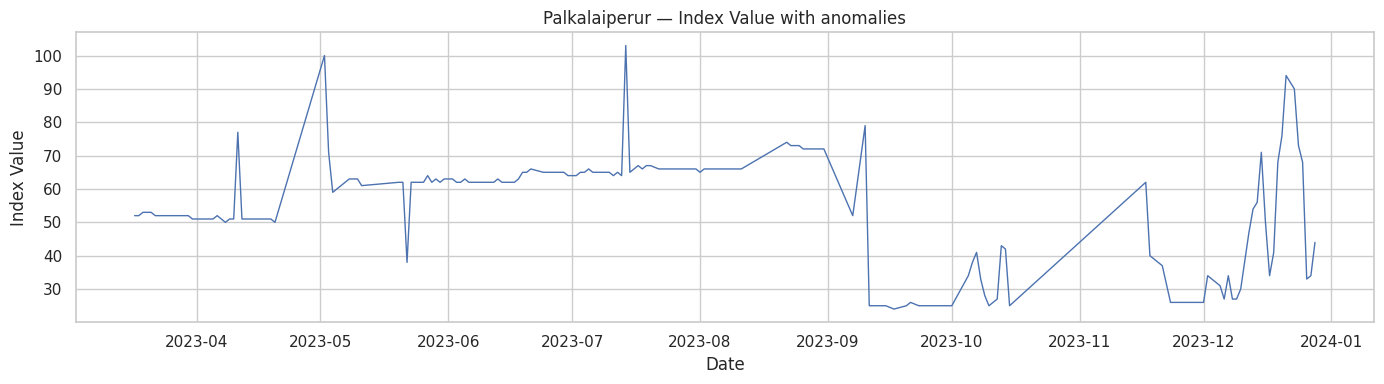

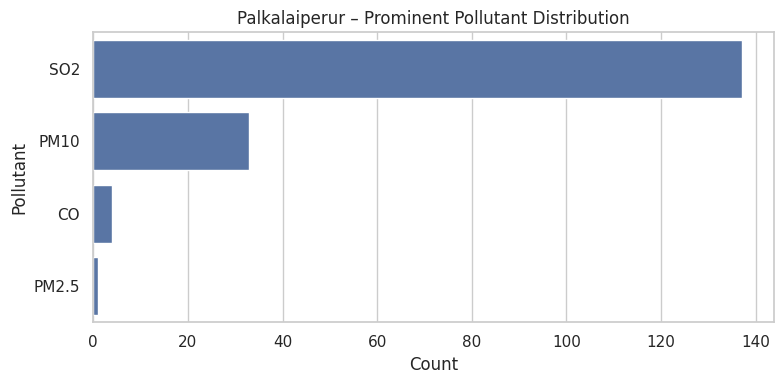


Task 1 Completed Successfully.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

CSV_PATH = "/content/Palkalaiperur_AQIBulletins.csv"
CITY = "Delhi"

df_all = pd.read_csv(CSV_PATH)
df_all.columns = [c.strip() for c in df_all.columns]

city_col = None
for c in df_all.columns:
    if c.strip().lower() == "city":
        city_col = c
        break
if city_col is None:
    raise RuntimeError("City column not found.")

df_all[city_col] = df_all[city_col].astype(str).str.strip()
unique_cities = sorted(df_all[city_col].unique())
matched = df_all[df_all[city_col].str.lower() == CITY.strip().lower()]

if matched.empty:
    print(f"Requested city '{CITY}' not found.")
    print("Available cities:", unique_cities[:20])
    CITY = unique_cities[0]
    print(f"Proceeding with city '{CITY}'")
    df = df_all[df_all[city_col] == CITY].copy()
else:
    df = matched.copy()

date_col = None
for candidate in ["Date", "date", "DATE"]:
    if candidate in df.columns:
        date_col = candidate
        break
if date_col is None:
    for c in df.columns:
        if "date" in c.lower():
            date_col = c
            break
if date_col is None:
    raise RuntimeError("Date column not found.")

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.sort_values(date_col).reset_index(drop=True)

idx_col = None
for c in df.columns:
    if c.strip().lower() in ("index value", "indexvalue", "index_value", "index", "aqi"):
        idx_col = c
        break
if idx_col is None:
    cands = [c for c in df.columns if "index" in c.lower() or "aqi" in c.lower() or "value" in c.lower()]
    if cands:
        idx_col = cands[0]
if idx_col is None:
    raise RuntimeError("Index Value / AQI column not found.")

df[idx_col] = pd.to_numeric(df[idx_col], errors="coerce")

print(f"Analyzing city: {CITY}")
print(f"Using date column: {date_col}, index column: {idx_col}")
print("Rows:", len(df))
display(df.head(3))

sns.set_theme(style="whitegrid")

plt.figure(figsize=(14,4))
plt.plot(df[date_col], df[idx_col], linewidth=1)
plt.title(f"{CITY} – {idx_col} Over Time")
plt.xlabel("Date")
plt.ylabel(idx_col)
plt.tight_layout()
plt.show()

missing = df[idx_col].isna().sum()
print(f"\nMissing {idx_col} readings: {missing} ({missing/len(df):.2%})")
print("Date range:", df[date_col].min(), "→", df[date_col].max())

vals = df[idx_col]
mean, std = vals.mean(skipna=True), vals.std(skipna=True)
df["Z"] = (df[idx_col] - mean) / std
abnormal = df[df["Z"].abs() > 3]

print(f"\nAbnormal entries detected: {len(abnormal)}")
if not abnormal.empty:
    display(abnormal[[date_col, idx_col, "Z"]].head(10))
else:
    print("No outliers detected.")

plt.figure(figsize=(14,4))
plt.plot(df[date_col], df[idx_col], linewidth=1)
if not abnormal.empty:
    plt.scatter(abnormal[date_col], abnormal[idx_col], color="red", s=25)
plt.title(f"{CITY} — {idx_col} with anomalies")
plt.xlabel("Date")
plt.ylabel(idx_col)
plt.tight_layout()
plt.show()

poll_col = None
for c in df.columns:
    if "prominent" in c.lower() or "pollutant" in c.lower():
        poll_col = c
        break

if poll_col is None:
    print("Prominent Pollutant column not found.")
else:
    plt.figure(figsize=(8,4))
    poll_counts = df[poll_col].fillna("Unknown").value_counts().head(12)
    sns.barplot(y=poll_counts.index, x=poll_counts.values)
    plt.title(f"{CITY} – {poll_col} Distribution")
    plt.xlabel("Count")
    plt.ylabel("Pollutant")
    plt.tight_layout()
    plt.show()

print("\nTask 1 Completed Successfully.")


Requested city not found. Using default city: Palkalaiperur
Total daily rows for Palkalaiperur: 287
MAE  : 8.672
RMSE : 12.352


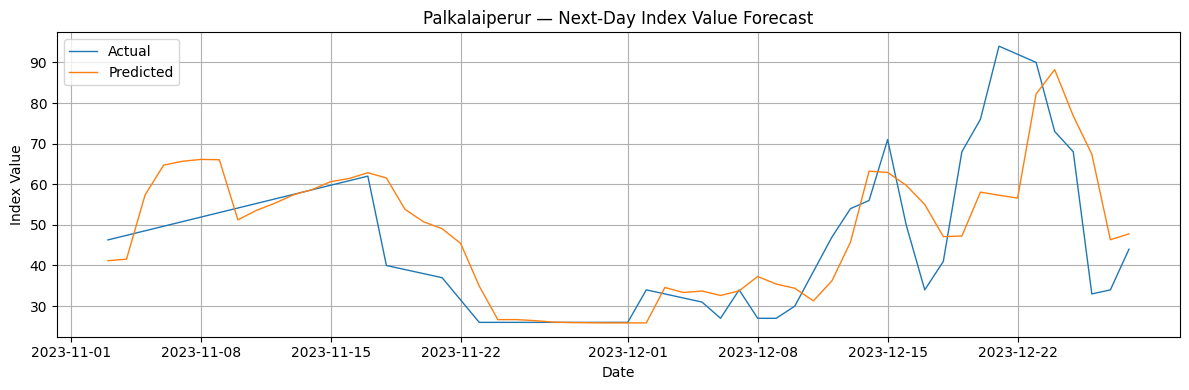

Task 2 Completed


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

CSV_PATH = "/content/Palkalaiperur_AQIBulletins.csv"
CITY = "Delhi"
WINDOW = 7

df_all = pd.read_csv(CSV_PATH)
df_all.columns = [c.strip() for c in df_all.columns]

city_col = None
for c in df_all.columns:
    if c.lower() == "city":
        city_col = c
        break

requested = df_all[df_all[city_col].str.lower() == CITY.lower()]
if requested.empty:
    CITY = sorted(df_all[city_col].unique())[0]
    print(f"Requested city not found. Using default city: {CITY}")
    df = df_all[df_all[city_col] == CITY].copy()
else:
    df = requested.copy()

date_col = None
for c in df.columns:
    if "date" in c.lower():
        date_col = c
        break

idx_col = None
for c in df.columns:
    if "index" in c.lower() or "aqi" in c.lower() or "value" in c.lower():
        idx_col = c
        break

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df[idx_col] = pd.to_numeric(df[idx_col], errors="coerce")
df = df.sort_values(date_col).dropna(subset=[idx_col])

df_daily = df.set_index(date_col)[idx_col].resample("D").mean().interpolate().to_frame()
print(f"Total daily rows for {CITY}: {len(df_daily)}")

values = df_daily[idx_col].values
X, y, date_targets = [], [], []
for i in range(WINDOW, len(values)):
    X.append(values[i-WINDOW:i])
    y.append(values[i])
    date_targets.append(df_daily.index[i])

X = np.array(X)
y = np.array(y)

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
dates_test = date_targets[split_index:]

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE  :", round(MAE, 3))
print("RMSE :", round(RMSE, 3))

plt.figure(figsize=(12,4))
plt.plot(dates_test[-100:], y_test[-100:], label="Actual", linewidth=1)
plt.plot(dates_test[-100:], y_pred[-100:], label="Predicted", linewidth=1)
plt.title(f"{CITY} — Next-Day Index Value Forecast")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Task 2 Completed")


Requested city not found. Using city: Palkalaiperur
Total daily rows for Palkalaiperur: 287


,Cluster Mean AQI
cluster,
1,29.271254
2,50.445527
0,67.356141


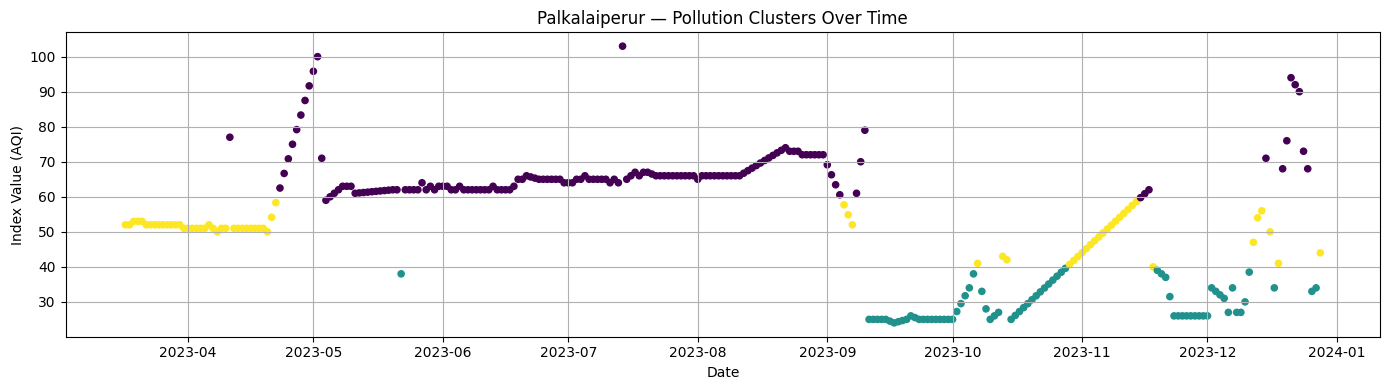

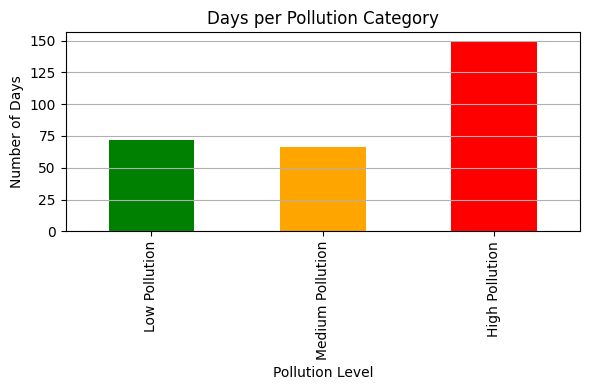

===== Cluster Interpretation =====
Cluster 1 → Low Pollution  |  Average Index Value: 29.27
Cluster 2 → Medium Pollution  |  Average Index Value: 50.45
Cluster 0 → High Pollution  |  Average Index Value: 67.36
Task 3 Completed


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from IPython.display import display

CSV_PATH = "/content/Palkalaiperur_AQIBulletins.csv"
CITY = "Delhi"

df_all = pd.read_csv(CSV_PATH)
df_all.columns = [c.strip() for c in df_all.columns]

city_col = None
for c in df_all.columns:
    if c.lower() == "city":
        city_col = c
        break
if city_col is None:
    raise RuntimeError("City column not found.")
requested = df_all[df_all[city_col].str.lower() == CITY.lower()]
if requested.empty:
    CITY = sorted(df_all[city_col].unique())[0]
    print(f"Requested city not found. Using city: {CITY}")

df = df_all[df_all[city_col].str.lower() == CITY.lower()].copy()

date_col = None
for c in df.columns:
    if "date" in c.lower():
        date_col = c
        break
if date_col is None:
    raise RuntimeError("Date column not found.")

idx_col = None
for c in df.columns:
    if "index" in c.lower() or "aqi" in c.lower() or "value" in c.lower():
        idx_col = c
        break
if idx_col is None:
    raise RuntimeError("Index/AQI column not found.")

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df[idx_col] = pd.to_numeric(df[idx_col], errors="coerce")
df = df.dropna(subset=[idx_col]).sort_values(date_col)

df_daily = df.set_index(date_col)[idx_col].resample("D").mean().interpolate().to_frame()
df_daily.columns = ["IndexValue"]

print(f"Total daily rows for {CITY}: {len(df_daily)}")

X = df_daily[["IndexValue"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_daily["cluster"] = kmeans.fit_predict(X_scaled)

cluster_means = df_daily.groupby("cluster")["IndexValue"].mean().sort_values()
order = cluster_means.index.tolist()

label_map = {
    order[0]: "Low Pollution",
    order[1]: "Medium Pollution",
    order[2]: "High Pollution"
}
df_daily["Pollution Level"] = df_daily["cluster"].map(label_map)

display(cluster_means.to_frame(name="Cluster Mean AQI"))

plt.figure(figsize=(14,4))
plt.scatter(df_daily.index, df_daily["IndexValue"], c=df_daily["cluster"], cmap="viridis", s=20)
plt.title(f"{CITY} — Pollution Clusters Over Time")
plt.ylabel("Index Value (AQI)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df_daily["Pollution Level"].value_counts().reindex(["Low Pollution","Medium Pollution","High Pollution"]).plot(kind='bar', color=['green','orange','red'])
plt.title("Days per Pollution Category")
plt.xlabel("Pollution Level")
plt.ylabel("Number of Days")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("===== Cluster Interpretation =====")
for cid in order:
    level = label_map[cid]
    mean_val = df_daily[df_daily["cluster"] == cid]["IndexValue"].mean()
    print(f"Cluster {cid} → {level}  |  Average Index Value: {mean_val:.2f}")

print("Task 3 Completed")


In [9]:


import pandas as pd
import numpy as np
from IPython.display import display

CSV_PATH = "/content/Palkalaiperur_AQIBulletins.csv"
CITY = "Delhi"
OUT_MONTHLY = "monthly_pollution_summary.csv"



df_all = pd.read_csv(CSV_PATH)
df_all.columns = [c.strip() for c in df_all.columns]


city_col = None
for c in df_all.columns:
    if c.strip().lower() == "city":
        city_col = c
        break
if city_col is None:
    raise RuntimeError("Couldn't find 'City' column. Columns found: " + ", ".join(df_all.columns))


requested = df_all[df_all[city_col].astype(str).str.strip().str.lower() == CITY.strip().lower()]
if requested.empty:
    available = sorted(df_all[city_col].astype(str).unique().tolist())
    print(f"Requested city '{CITY}' not found. Available cities sample: {available[:10]}")
    CITY = available[0]
    print(f"Proceeding with city: {CITY}")
    df_city = df_all[df_all[city_col].astype(str) == CITY].copy()
else:
    df_city = requested.copy()


date_col = next((c for c in df_city.columns if 'date' in c.lower()), None)
if date_col is None:
    raise RuntimeError("Could not find a date column.")

idx_col = next((c for c in df_city.columns if 'index' in c.lower() or 'aqi' in c.lower() or ('value' in c.lower() and 'index' in c.lower()) ), None)
if idx_col is None:

    cand = [c for c in df_city.columns if 'index' in c.lower() or 'value' in c.lower() or 'aqi' in c.lower()]
    if cand:
        idx_col = cand[0]
    else:
        raise RuntimeError("Could not find 'Index Value' column. Columns: " + ", ".join(df_city.columns))


df_city[date_col] = pd.to_datetime(df_city[date_col], errors='coerce')
df_city[idx_col] = pd.to_numeric(df_city[idx_col], errors='coerce')
df_city = df_city.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)


df_daily = df_city.set_index(date_col)[idx_col].resample('D').mean().interpolate()
monthly = df_daily.resample('M').mean().reset_index().rename(columns={date_col: 'Month', idx_col: 'IndexValue'})


if monthly.empty:
    raise RuntimeError("No monthly data available for city: " + CITY)


q33 = monthly['IndexValue'].quantile(0.33)
q66 = monthly['IndexValue'].quantile(0.66)

def categorize(v):
    if v <= q33:
        return "Clean"
    elif v <= q66:
        return "Moderate"
    else:
        return "High"

monthly['Category'] = monthly['IndexValue'].apply(categorize)
monthly['MonthStr'] = monthly['Month'].dt.strftime('%b %Y')


monthly['isHigh'] = monthly['Category'] == 'High'

monthly['grp'] = (monthly['isHigh'] != monthly['isHigh'].shift()).cumsum()
high_runs = (monthly[monthly['isHigh']]
             .groupby('grp')
             .agg(start=('Month','min'), end=('Month','max'), length=('Month','count'))
             .reset_index(drop=True))


multi_month_high = high_runs[high_runs['length'] > 1]


high_months = monthly[monthly['Category'] == 'High']['MonthStr'].tolist()
top3 = monthly.sort_values('IndexValue', ascending=False).head(3)
top3_list = top3['MonthStr'].tolist()

if len(high_months) == 0:
    insight = (f"{CITY}: No months were categorized as 'High' pollution by monthly average in the dataset. "
               "Most months fall under Clean or Moderate categories based on the dataset quantiles.")
else:
    insight = (f"{CITY}: Months with consistently higher monthly-average Index Values include: {', '.join(high_months)}. "
               f"Top months by average Index Value: {', '.join(top3_list)}. "
               "These months may need prioritized mitigation measures and public advisories (e.g., dust control, restriction of certain activities, awareness campaigns).")
    if not multi_month_high.empty:
        insight += (" Note: there are multi-month high-pollution runs, indicating a seasonal trend requiring sustained intervention during those periods.")


monthly_out = monthly[['Month','MonthStr','IndexValue','Category']]
monthly_out.to_csv(OUT_MONTHLY, index=False)
print(f"Saved monthly summary to: {OUT_MONTHLY}\n")


print("=== Monthly summary (first 12 rows) ===")
display(monthly_out.head(12))

print("\n=== Detected high-month runs (summary) ===")
if high_runs.empty:
    print("No high-month runs detected.")
else:
    # format runs
    runs_display = high_runs.copy()
    runs_display['start'] = runs_display['start'].dt.strftime('%b %Y')
    runs_display['end']   = runs_display['end'].dt.strftime('%b %Y')
    display(runs_display)

print("\n=== AUTOMATED SEASONAL INSIGHT ===")
print(insight)

print("\n🎯 Task 4 Completed.")


Requested city 'Delhi' not found. Available cities sample: ['Palkalaiperur']
Proceeding with city: Palkalaiperur
Saved monthly summary to: monthly_pollution_summary.csv

=== Monthly summary (first 12 rows) ===


/tmp/ipython-input-331794771.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_daily.resample('M').mean().reset_index().rename(columns={date_col: 'Month', idx_col: 'IndexValue'})


,Month,MonthStr,IndexValue,Category
0,2023-03-31,Mar 2023,52.133333,Moderate
1,2023-04-30,Apr 2023,59.138889,Moderate
2,2023-05-31,May 2023,63.704301,High
3,2023-06-30,Jun 2023,63.400000,High
4,2023-07-31,Jul 2023,66.758065,High
5,2023-08-31,Aug 2023,69.354839,High
6,2023-09-30,Sep 2023,37.766667,Clean
7,2023-10-31,Oct 2023,33.160802,Clean
8,2023-11-30,Nov 2023,43.167172,Clean
9,2023-12-31,Dec 2023,48.732143,Moderate



=== Detected high-month runs (summary) ===


,start,end,length
0,May 2023,Aug 2023,4



=== AUTOMATED SEASONAL INSIGHT ===
Palkalaiperur: Months with consistently higher monthly-average Index Values include: May 2023, Jun 2023, Jul 2023, Aug 2023. Top months by average Index Value: Aug 2023, Jul 2023, May 2023. These months may need prioritized mitigation measures and public advisories (e.g., dust control, restriction of certain activities, awareness campaigns). Note: there are multi-month high-pollution runs, indicating a seasonal trend requiring sustained intervention during those periods.

🎯 Task 4 Completed.
